In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import pyplot, patches
import plotly.express as px
import numpy as np
import pandas as pd
from library import tools, evals, architectures
from evaluation import deep_features_plot
import os
import pathlib
import torch
from torch.nn import functional as F

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Functions

In [4]:
def recall_oscr_results(which='MultiBinary', arch='LeNet_plus_plus', dataset='SmallScale'):
    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{dataset}/eval_{arch}/{which}/oscr'
    print(root_path, which)
    oscr_results = [
        np.load(os.path.join(root_path,'ccr.npy')),
        np.load(os.path.join(root_path,'fpr_neg.npy')),
        np.load(os.path.join(root_path,'fpr_unkn.npy')),
        ]
    return oscr_results

In [5]:
def recall_pred_results(which='MultiBinary', arch='LeNet_plus_plus', dataset='SmallScale'):
    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{dataset}/eval_{arch}'
    print(root_path, which)
    pred_results = {}
    if dataset == 'SmallScale':
        pred_results['train'] = [np.load(os.path.join(root_path, which, 'pred', 'train_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'train_logits.npy')), np.load(os.path.join(root_path, which, 'pred', 'train_feats.npy')), np.load(os.path.join(root_path, which, 'pred', 'train_probs.npy'))]
        pred_results['test_neg'] = [np.load(os.path.join(root_path, which, 'pred', 'test_neg_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_neg_logits.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_neg_feats.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_neg_probs.npy'))]
        pred_results['test_unkn'] = [np.load(os.path.join(root_path, which, 'pred', 'test_unkn_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_unkn_logits.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_unkn_feats.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_unkn_probs.npy'))]
    else:
        pred_results['test_neg'] = [np.load(os.path.join(root_path, which, 'pred', 'test_neg_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_neg_logits.npy')), None, np.load(os.path.join(root_path, which, 'pred', 'test_neg_probs.npy'))]
        pred_results['test_unkn'] = [np.load(os.path.join(root_path, which, 'pred', 'test_unkn_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_unkn_logits.npy')), None, np.load(os.path.join(root_path, which, 'pred', 'test_unkn_probs.npy'))]        
    return pred_results

In [6]:
def get_net(which):
    model_root='/home/user/hkim/UZH-MT/openset-binary/_models'
    network_file = os.path.join(model_root, f"SmallScale/LeNet_plus_plus/{which}/{which}.model")

    if which == 'Garbage':
        num_classes = 11
    else:
        num_classes = 10

    net = architectures.__dict__["LeNet_plus_plus"](small_scale=True,
                                                    use_BG=False,
                                                    num_classes=num_classes)
    net.load_state_dict(torch.load(network_file, map_location=torch.device('cpu')))
    return net

In [7]:
def plot_multiple_linear_functions(param_list):
    """
    Plots multiple linear functions ax + by = 1 given a list of coefficient pairs [[a1, b1], [a2, b2], ...].

    Args:
        coefficients_list (list of lists): List of coefficient pairs [[a1, b1], [a2, b2], ...].
    """
    pyplot.figure(figsize=(8, 6))
    x_values = np.linspace(-10000, 10000, 100)

    for i, coefficients in enumerate(param_list):
        a, b = coefficients
        slope = -a / b
        intercept = 1 / b
        y_values = slope * x_values + intercept
        pyplot.plot(x_values, y_values, label=f"{i}", color = pyplot.cm.tab10(i))

    pyplot.xlabel('x')
    pyplot.ylabel('y')
    pyplot.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    pyplot.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    pyplot.grid(True)
    pyplot.legend()


In [14]:
def get_stats(gt, logits, label):
    pos = gt == label
    unkn = gt == -1
    neg = ~(pos | unkn)
    
    print(f"Total: {len(gt)} \t gt=={label}: {sum(pos)} \t unkn: {sum(unkn)} \t neg: {sum(neg)}")

    pos_logits = logits[pos,label]
    unkn_logits = logits[unkn,label]
    neg_logits = logits[neg,label]

    print(f"pos_logit_min_max: {np.min(pos_logits):.2f}~{np.max(pos_logits):.2f}")
    print(f"unkn_logit_min_max: {np.min(unkn_logits):.2f}~{np.max(unkn_logits):.2f}")
    print(f"neg_logit_min_max: {np.min(neg_logits):.2f}~{np.max(neg_logits):.2f}")

    return pos_logits, unkn_logits, neg_logits

# Logit Distribution

In [25]:
which = 'MultiBinary'
dataset = 'SmallScale'
arch = 'LeNet_plus_plus_moon_batch'
# LeNet_plus_plus
# LeNet_plus_plus_moon_global       LeNet_plus_plus_moon_batch

unkn_gt_label = -1

pred_results = recall_pred_results(which, arch, dataset)

# gt, logits, feats, probs = pred_results['train']
# gt, logits, feats, probs = pred_results['test_neg']
gt, logits, feats, probs = pred_results['test_unkn']

/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/eval_LeNet_plus_plus_moon_batch MultiBinary


Total: 18800 	 gt==0: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -101.59~8.95
unkn_logit_min_max: -1903.17~13.94
neg_logit_min_max: -1748.93~7.73


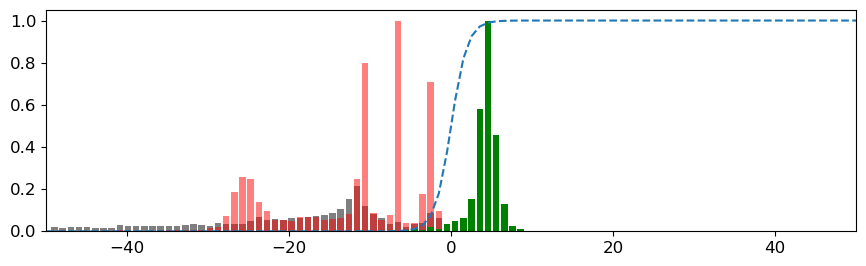

Total: 18800 	 gt==1: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -2067.52~10.07
unkn_logit_min_max: -18517.56~10.50
neg_logit_min_max: -16627.44~10.33


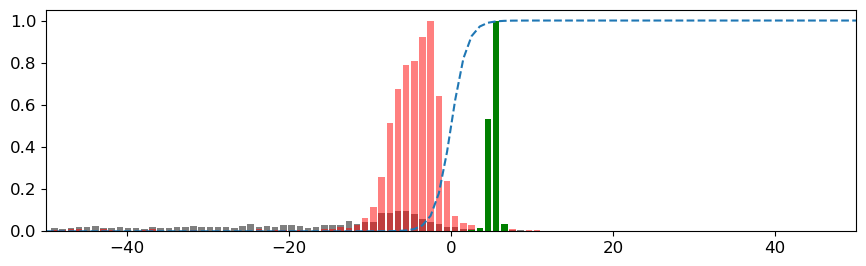

Total: 18800 	 gt==2: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -7.39~20.30
unkn_logit_min_max: -12.12~21.37
neg_logit_min_max: -10.71~3.89


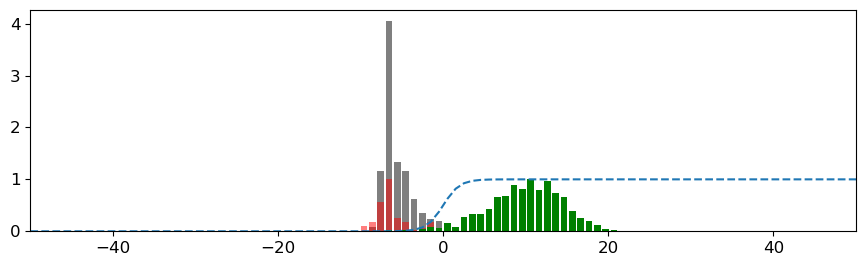

Total: 18800 	 gt==3: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -36.88~12.01
unkn_logit_min_max: -207.46~20.38
neg_logit_min_max: -198.73~6.90


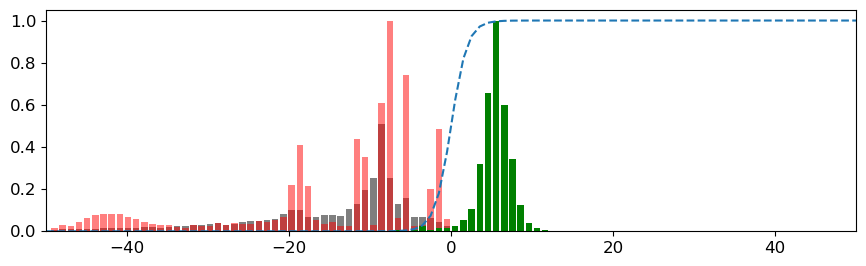

Total: 18800 	 gt==4: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -1728.20~7.56
unkn_logit_min_max: -12802.23~17.20
neg_logit_min_max: -11315.87~6.42


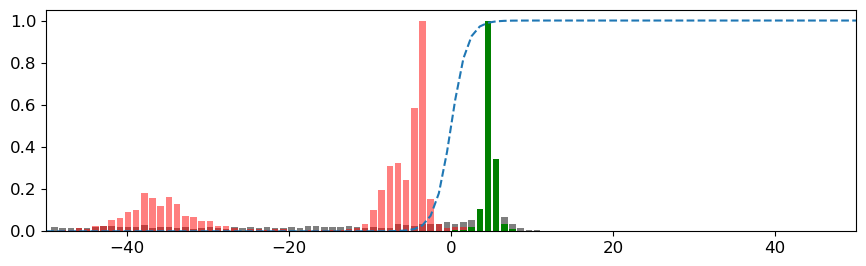

Total: 18800 	 gt==5: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -91.50~11.13
unkn_logit_min_max: -1034.29~19.47
neg_logit_min_max: -1077.86~7.42


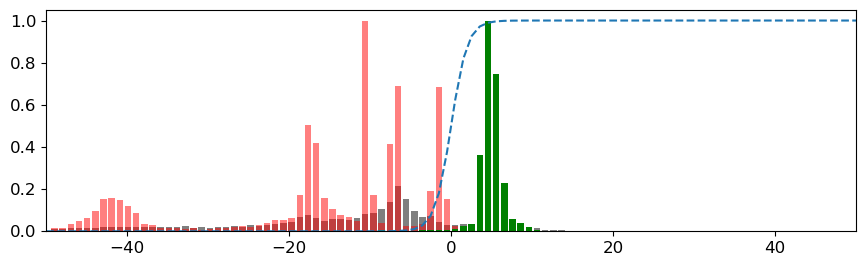

Total: 18800 	 gt==6: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -5.57~14.19
unkn_logit_min_max: -14.02~6.01
neg_logit_min_max: -13.03~-0.52


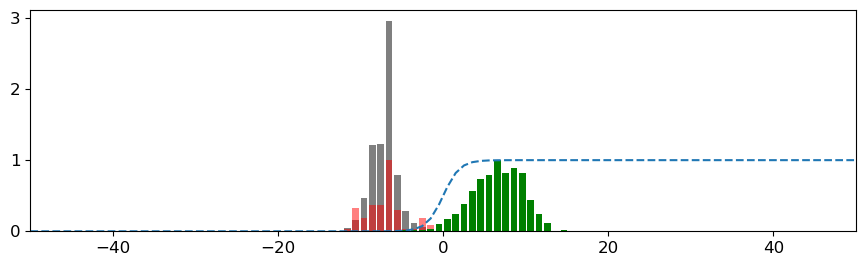

Total: 18800 	 gt==7: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -655.51~17.51
unkn_logit_min_max: -7301.40~13.31
neg_logit_min_max: -6376.23~9.74


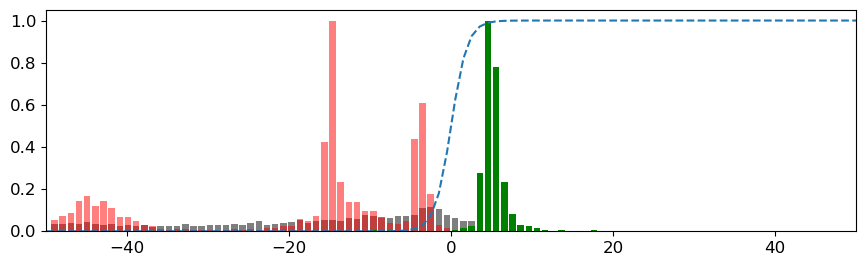

Total: 18800 	 gt==8: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -7.94~11.54
unkn_logit_min_max: -71.55~15.69
neg_logit_min_max: -116.55~6.41


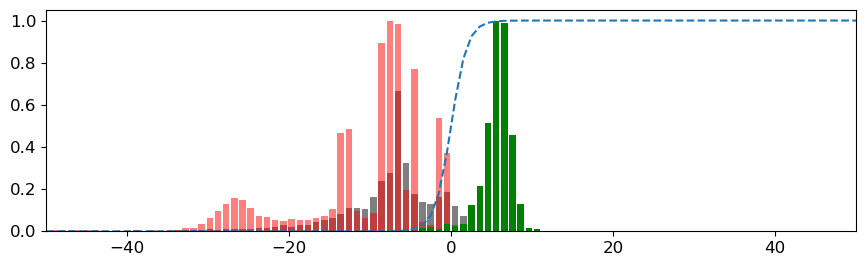

Total: 18800 	 gt==9: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -106.29~18.09
unkn_logit_min_max: -12601.37~19.78
neg_logit_min_max: -11425.29~2.35


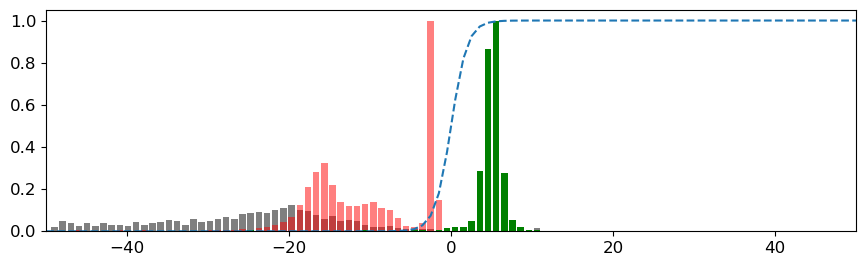

In [26]:
for i in range(10):
    label = i
    pos_logits, unkn_logits, neg_logits = get_stats(gt, logits, label)
    xrange = (-50,50)
    bins = np.linspace(xrange[0],xrange[1],100)
    pos_hist = np.histogram(pos_logits, bins=bins, density=True)
    unkn_hist = np.histogram(unkn_logits, bins=bins, density=True,)
    neg_hist = np.histogram(neg_logits, bins=bins, density=True,)

    fig, ax = pyplot.subplots(figsize=(9, 3))
    ax.bar(
        unkn_hist[1][1:],
        unkn_hist[0].astype(np.float16) / max(pos_hist[0]),
        label='unkn',
        color="black",
        alpha=0.5
    )
    ax.bar(
        neg_hist[1][1:],
        neg_hist[0].astype(np.float16) / max(neg_hist[0]),
        color="r",
        label='neg',
        alpha=0.5
    )
    ax.bar(
        pos_hist[1][1:],
        pos_hist[0].astype(np.float16) / max(pos_hist[0]),
        label=label,
        color="g",
        alpha=1
    )

    ax.plot(bins, 1/(1+np.exp(-bins)), linestyle='--')

    ax.tick_params(axis="both", which="major", labelsize=12)

    pyplot.xlim(xrange[0],xrange[1])
    pyplot.tight_layout()
    pyplot.savefig(f'{i}_logit.png')
    pyplot.show()

# Binary Classifier Deep Feature Space

In [32]:
which = 'MultiBinary'
dataset = 'SmallScale'
arch = 'LeNet_plus_plus_moon_global'
# LeNet_plus_plus
# LeNet_plus_plus_moon_global       LeNet_plus_plus_moon_batch


unkn_gt_label = -1

pred_results = recall_pred_results(which, arch, dataset)

/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/eval_LeNet_plus_plus_moon_global MultiBinary


In [36]:
df = pd.DataFrame(data = {'x': pred_results['train'][2][:,0], 'y': pred_results['train'][2][:,1], 'label':pred_results['train'][0]})
df = df.loc[df['label'] != -1]
df["label"] = df["label"].astype(str)

fig = px.scatter(df, x="x", y="y", color="label", color_discrete_sequence=px.colors.qualitative.D3,
                 category_orders={'label': np.sort(df['label'].unique())},
                 labels=['label'], width=500, height=500)

# Case. Bias = False
# fig.update_xaxes(range=[-1000, 14000], title=None)
# fig.update_yaxes(range=[-2000,1000], title=None)

# Case. Bias = True
fig.update_xaxes(range=[-100, 700], title=None)
fig.update_yaxes(range=[-2700,100], title=None)

fig.update_layout(
    margin=dict(l=5, r=5, t=5, b=5),
)

fig.show()

# Confusion Matrix

In [7]:
which = 'MultiBinary'   # SoftMax   Garbage    EOS    MultiBinary
dataset = 'LargeScale'  # SmallScale   LargeScale   LargeScale_2    LargeScale_3
arch = 'ResNet_18_moon_batch'
# LeNet_plus_plus       LeNet_plus_plus_moon_global     LeNet_plus_plus_moon_batch
# ResNet_18     ResNet_18_moon_global       ResNet_18_moon_batch

unkn_gt_label_info = {
    'SmallScale': 10,
    'LargeScale': 116, 'LargeScale_2': 30, 'LargeScale_3': 151
}

if which != 'Garbage':
    unkn_gt_label = -1     # -1 10 116 30 151
else:
    unkn_gt_label = unkn_gt_label_info[dataset]

pred_results = recall_pred_results(which, arch, dataset)
print(np.unique(pred_results['test_unkn'][0]))
print(np.unique(np.argmax(pred_results['test_unkn'][3], axis=1)))

/home/user/hkim/UZH-MT/openset-binary/_results/LargeScale/eval_ResNet_18_moon_batch MultiBinary
[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 10

## Train Set

In [ ]:
df = pd.DataFrame(data = {'gt': pred_results['train'][0], 'pred': np.argmax(pred_results['train'][3], axis=1)})
if which != 'Garbage':
    df = df.loc[df['gt'] != unkn_gt_label]
print(np.unique(df['gt']), np.unique(df['pred']))
fig, ax = pyplot.subplots(figsize=(17,17))

include_values = False
if dataset == 'SmallScale':
    include_values = True

ConfusionMatrixDisplay.from_predictions(df['gt'], df['pred'],
                                        normalize='true', values_format='.2f',
                                        include_values=include_values, 
                                        cmap=pyplot.cm.Blues, ax=ax)
pyplot.show()


## Test Set

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115] [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115]


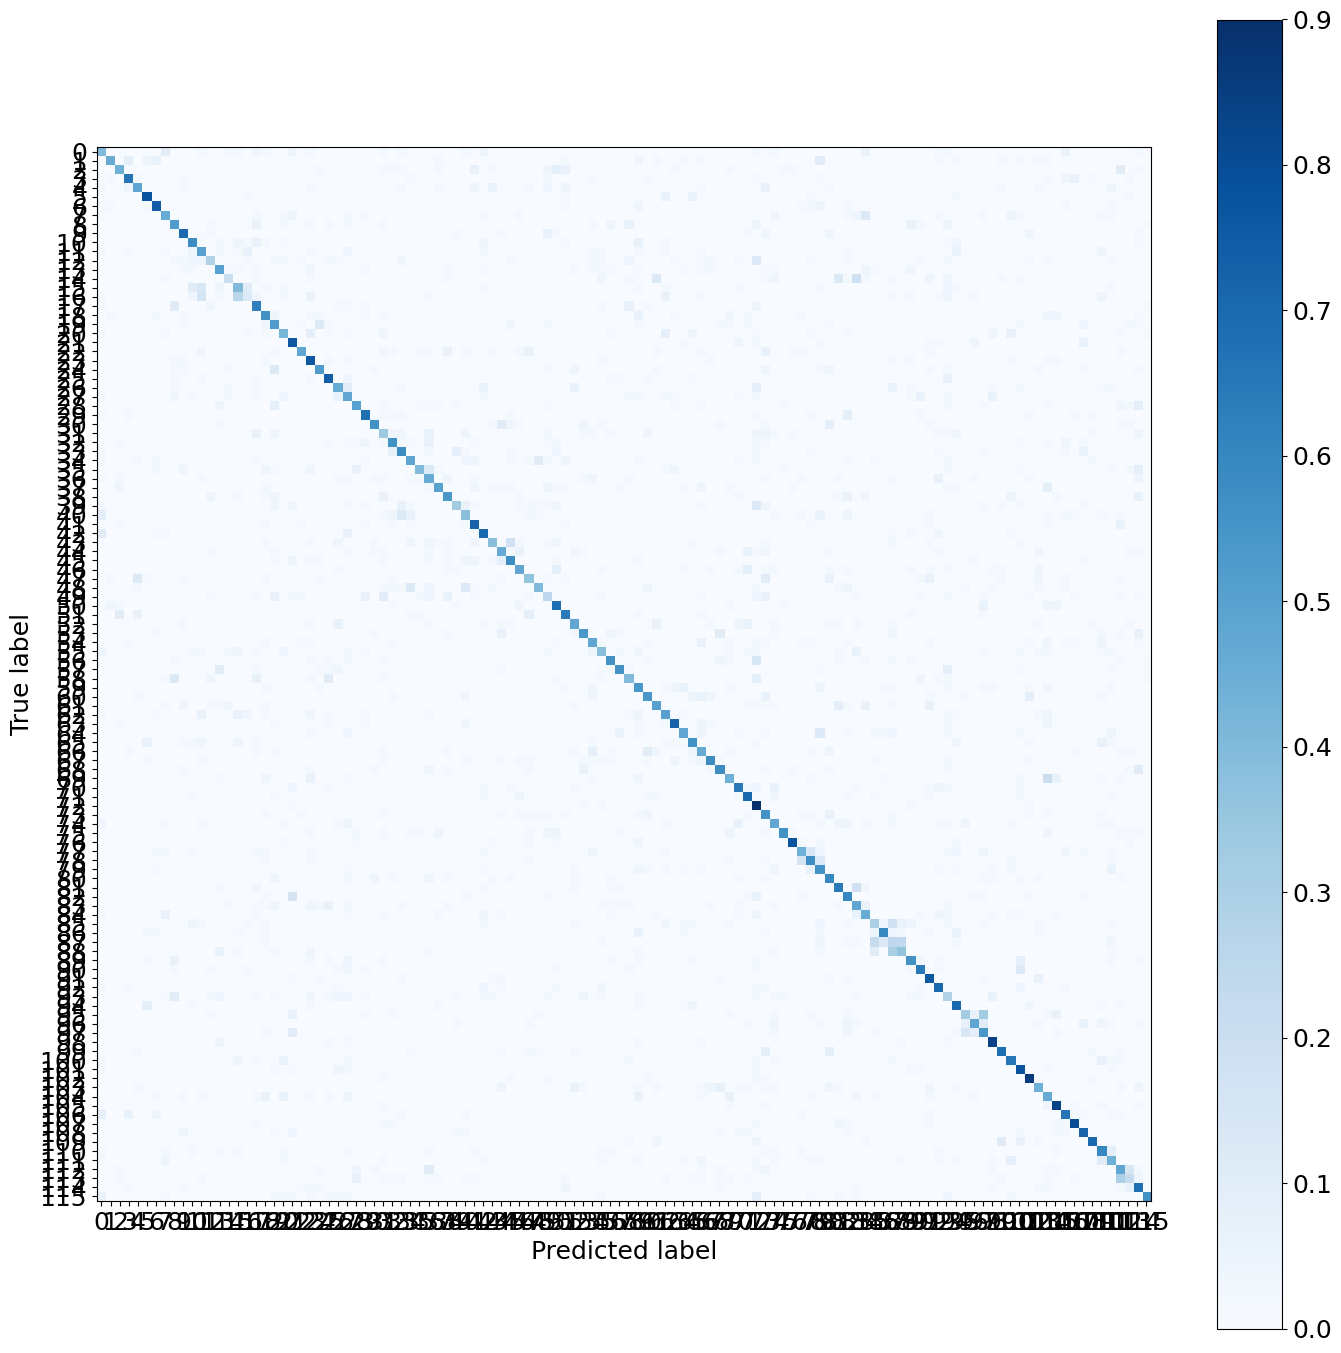

In [8]:
df = pd.DataFrame(data = {'gt': pred_results['test_unkn'][0], 'pred': np.argmax(pred_results['test_unkn'][3], axis=1)})
if which != 'Garbage':
    df = df.loc[df['gt'] != unkn_gt_label]
print(np.unique(df['gt']), np.unique(df['pred']))

fig, ax = pyplot.subplots(figsize=(17,17))

include_values = False
if dataset == 'SmallScale':
    include_values = True

ConfusionMatrixDisplay.from_predictions(df['gt'], df['pred'],
                                        normalize='true', values_format='.2f',
                                        include_values=include_values, 
                                        cmap=pyplot.cm.Blues, ax=ax)
pyplot.show()

# OSCR Curve

In [43]:
# [
#       SmallScale   LargeScale   LargeScale_2    LargeScale_3 ,
#
#       LeNet_plus_plus       LeNet_plus_plus_moon_global     LeNet_plus_plus_moon_batch ,
#       ResNet_18     ResNet_18_moon_global       ResNet_18_moon_batch , 
#
#       SoftMax   Garbage    EOS    MultiBinary ,
# ]

oscr_plots = [
    {'info':['LargeScale_3','ResNet_18','SoftMax'],'label':'Plain SoftMax','alpha':0.2},
    {'info':['LargeScale_3','ResNet_18','Garbage'],'label':'Garbage Class','alpha':0.2},
    {'info':['LargeScale_3','ResNet_18','EOS'],'label':'Entropic Open-Set','alpha':0.2},
    {'info':['LargeScale_3','ResNet_18','MultiBinary'],'label':'MBC: Multiple Binary Classifiers','alpha':1},
    {'info':['LargeScale_3','ResNet_18_moon_global','MultiBinary'],'label':'MBC + MOON (Global)','alpha':1},
    {'info':['LargeScale_3','ResNet_18_moon_batch','MultiBinary'],'label':'MBC + MOON (Batch)','alpha':1},
]

In [44]:
results = []

for item in oscr_plots:
    info = item['info']
    oscr_results = recall_oscr_results(which=info[2], arch=info[1], dataset=info[0])
    results.append(oscr_results)

/home/user/hkim/UZH-MT/openset-binary/_results/LargeScale_3/eval_ResNet_18/SoftMax/oscr SoftMax
/home/user/hkim/UZH-MT/openset-binary/_results/LargeScale_3/eval_ResNet_18/Garbage/oscr Garbage
/home/user/hkim/UZH-MT/openset-binary/_results/LargeScale_3/eval_ResNet_18/EOS/oscr EOS
/home/user/hkim/UZH-MT/openset-binary/_results/LargeScale_3/eval_ResNet_18/MultiBinary/oscr MultiBinary
/home/user/hkim/UZH-MT/openset-binary/_results/LargeScale_3/eval_ResNet_18_moon_global/MultiBinary/oscr MultiBinary
/home/user/hkim/UZH-MT/openset-binary/_results/LargeScale_3/eval_ResNet_18_moon_batch/MultiBinary/oscr MultiBinary


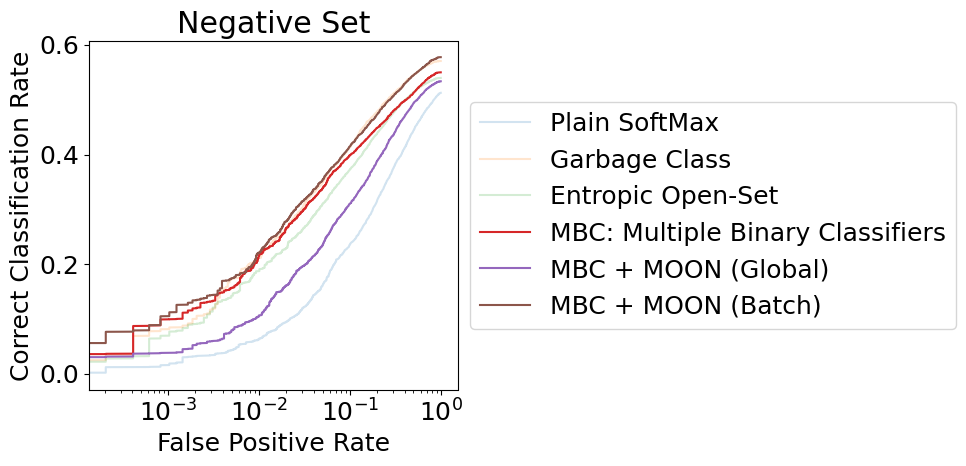

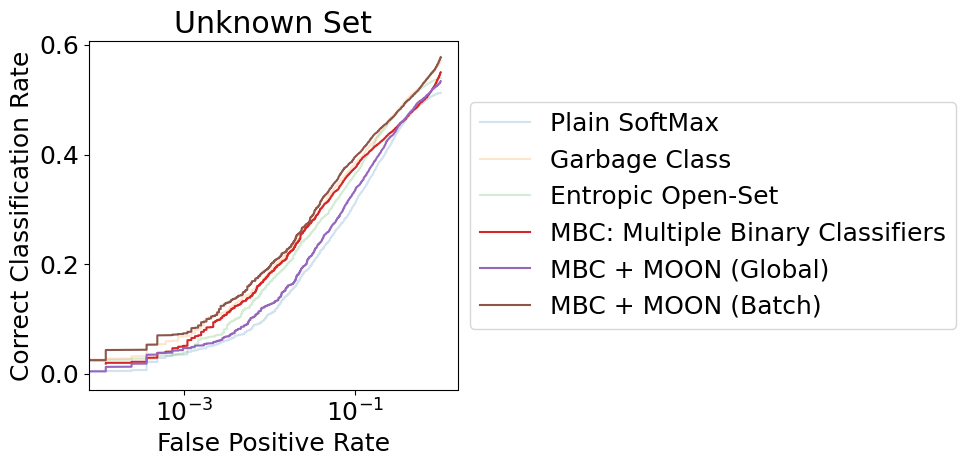

In [45]:
# plot with known unknowns
pyplot.figure(figsize=(10,5))
for idx, res in enumerate(results):
    pyplot.semilogx(res[1], res[0], label=oscr_plots[idx]['label'], alpha=oscr_plots[idx]['alpha'])
pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("Correct Classification Rate")
pyplot.title("Negative Set")
pyplot.tight_layout()
# pyplot.savefig(root.joinpath('oscr_neg.png'), bbox_inches="tight") 

# plot with unknown unknowns
pyplot.figure(figsize=(10,5))
for idx, res in enumerate(results):
    pyplot.semilogx(res[2], res[0], label=oscr_plots[idx]['label'], alpha=oscr_plots[idx]['alpha'])
pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("Correct Classification Rate")
pyplot.title("Unknown Set")
pyplot.tight_layout()
# pyplot.savefig(root.joinpath('oscr_unkn.png'), bbox_inches="tight") 